In [ ]:
!pip install einops

In [ ]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as TF
from torchvision import models, datasets
from torchvision import tv_tensors

from tqdm.notebook import tqdm

import einops
import numpy as np
from matplotlib import pyplot as plt
from random import randint

import torchvision.datasets as dset
import json
from PIL import Image, ImageDraw

from itertools import product

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Part 1: Loading VOC Dataset

In [ ]:
S, B, C = 7, 2, 20

In [ ]:
class VOCDataset(Dataset):
    def __init__(self, orig_dataset, classes, transform=None):
      self.orig_dataset = orig_dataset
      self.classes = classes
      self.transform = transform

    def __len__(self):
        """
        When you inherit from Dataset you always need to specify a __len__ method.
        Otherwise, how would your DataLoader know when to stop!?
        """
        return len(self.orig_dataset)

    def _get_normalised_box(self, idx, obj, img_size: tuple[int, int]):
        """
        The VOCDataset has boxes in an xmin, ymin, xmax, ymax format, but we need our boxes
        to be in the YOLO format which is an (x, y) representing the center and
        the width and height of the box.
        We return the converted box and the cell (x, y) which the box is centered in
        """
        x_min, y_min, x_max, y_max = obj

        cell_width, cell_height = img_size[0] / S, img_size[1] / S

        box_center_x, box_center_y = (x_max - x_min) / 2 + x_min, (y_max - y_min) / 2 + y_min
        cell_num_x, cell_num_y = int(box_center_x // cell_width), int(box_center_y // cell_height)
        assert cell_num_x < S and cell_num_y < S, f"Box is out of bounds!, {idx, x_min, y_min, x_max, y_max, box_center_x, cell_width, box_center_y, cell_height}"
        box_x, box_y = (box_center_x % (cell_width)) / cell_width , (box_center_y % cell_height) / cell_height

        box_w, box_h = (x_max - x_min) / img_size[0], (y_max - y_min) / img_size[1]
        box = torch.tensor([box_x, box_y, box_w, box_h])

        return box, (cell_num_y, cell_num_x)


    def __getitem__(self, idx):
        """
        We need a way to go from an index to the data we want!
        We return a normalized img formatted as a tensor
        And, we want our labels in shape (S, S, 5 * B + C)
        """
        img, label = self.orig_dataset[idx]
        img = T.ToTensor()(img)

        boxes = [[int(obj["bndbox"][i]) for i in ["xmin", "ymin", "xmax", "ymax"]] for obj in label["annotation"]["object"]]
        boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.shape[-2:])
        classes = [obj["name"] for obj in label["annotation"]["object"]]

        if self.transform:
            img, boxes = self.transform(img, boxes)

        onehot_ls = torch.eye(len(self.classes))
        one = torch.tensor([1])

        out = torch.zeros((S, S, 5 * B + len(self.classes)))

        bboxes = {}

        for obj_name, box_ in zip(classes, boxes):
            x_min, y_min, x_max, y_max = box_
            if x_min >= x_max or y_min >= y_max:
                continue

            box, (y, x) = self._get_normalised_box(idx, box_, (img.shape[-1], img.shape[-2]))

            detection_zone = out[y][x]

            class_probs = onehot_ls[self.classes.index(obj_name)]
            detection_zone[5*B:] = class_probs

            bbox_id = bboxes.get((y, x), 0)
            if bbox_id < B:
                bboxes[(y, x)] = bbox_id + 1
                for i in range(bbox_id, B):
                    detection_zone[5*i:5*(i+1)] = torch.concat([one, box], dim=-1)

        return img, out

In [ ]:
data_root = '/data/voc'
train_size = 2304 * 4
val_size = 2304

dataset = torchvision.datasets.VOCDetection(
    root=data_root,
    year='2012',
    image_set='trainval',
    download=True,
    transform=None,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
                                              "Please lower the train or validation set sizes."

train_temp_set = torch.utils.data.Subset(dataset, range(train_size))
val_temp_set = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))

In [ ]:
image_size = 224

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.Resize((image_size, image_size), antialias=True),
    T.ColorJitter(saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=0),
    T.Normalize(mean, std)
])

valid_transform = T.Compose([
    T.Resize((image_size, image_size), antialias=True),
    T.Normalize(mean, std)
])

unnormalize = T.Normalize((-mean / std), (1.0 / std))

classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
          'bus', 'car', 'cat', 'chair', 'cow',
          'diningtable', 'dog', 'horse', 'motorbike', 'person',
          'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

train_set = VOCDataset(train_temp_set, classes, train_transform)
val_set = VOCDataset(val_temp_set, classes, valid_transform)

Again, like we did for the CIFAR dataset in HW 2A, let's visualize some of the images in the Pascal VOC dataset.

In [ ]:
def retrieve_bboxes(bboxes):
    boxes_ls, classes_ls, scores_ls = [], [], []

    cell_size = image_size / S

    for sy in range(S):
        for sx in range(S):
            cell = bboxes[sy][sx]
            for b in range(B):
                if cell[5 * b] > 0.0:

                    class_num = torch.argmax(cell[5*B:], dim=-1)
                    class_label = classes[class_num]
                    classes_ls.append(class_label)
                    scores_ls.append(cell[5 * b])

                    y1 = cell_size * (sy + cell[5 * b + 2]) - (image_size * cell[5 * b + 4] / 2)
                    x1 = cell_size * (sx + cell[5 * b + 1]) - (image_size * cell[5 * b + 3] / 2)
                    y2 = y1 + image_size * cell[5 * b + 4]
                    x2 = x1 + image_size * cell[5 * b + 3]

                    xyxy = [x1, y1, x2, y2]

                    boxes_ls.append(xyxy)

    return boxes_ls, classes_ls, scores_ls

def visualize(image, bboxes_ls, classes_ls, scores_ls):
    img = unnormalize(image)
    img = T.Resize((448, 448), antialias=True)(img)
    img = T.ToPILImage()(img)
    draw = ImageDraw.Draw(img)

    for box, class_, score in zip(bboxes_ls, classes_ls, scores_ls):
        box = [i * 448 / image_size for i in box]
        draw.rectangle(box, outline=(255, 0, 0))
        box_text = f" {class_} {score:4.2f} "
        annotation_pos = (box[0], box[1] - 11)
        annotation_box = draw.textbbox(annotation_pos, box_text)
        draw.rectangle(annotation_box, fill=(255, 0, 0), outline=(255, 0, 0))
        draw.text(annotation_pos, box_text, fill=(255, 255, 255))

    display(img)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

print('showing training images and boxes')
for i in range(10):
    images, bboxes = train_set[i]
    bboxes_ls, classes_ls, scores_ls = retrieve_bboxes(bboxes)
    visualize(images, bboxes_ls, classes_ls, scores_ls)

### Part 2: YOLO for Object Detection

In [ ]:
def batched_iou(preds, labels):
    """
    Compute the pairwise IOU between the predicted bounding boxes and the ground truth bounding boxes for each cell.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)

    returns: tensor of shape (N, S, S, B, B) containing the pairwise IOU between the predicted bounding boxes and the ground truth bounding boxes for each cell
    """
    N = labels.shape[0]

    x_labels, x_preds = labels[:, :, :, 1:5*B:5], preds[:, :, :, 1:5*B:5]
    y_labels, y_preds = labels[:, :, :, 2:5*B:5], preds[:, :, :, 2:5*B:5]
    w_labels, w_preds = labels[:, :, :, 3:5*B:5], preds[:, :, :, 3:5*B:5]
    h_labels, h_preds = labels[:, :, :, 4:5*B:5], preds[:, :, :, 4:5*B:5]

    cell_size = image_size / S
    # retrieve the coordinates of the bounding box rectangles for the labels
    x1_labels = cell_size * (x_labels + einops.repeat(torch.arange(S, device=labels.device), "S2 -> N S1 S2 B", N=N, S1=S, B=B)) - (image_size * w_labels / 2)
    y1_labels = cell_size * (y_labels + einops.repeat(torch.arange(S, device=labels.device), "S1 -> N S1 S2 B", N=N, S2=S, B=B)) - (image_size * h_labels / 2)
    x2_labels = x1_labels + image_size * w_labels
    y2_labels = y1_labels + image_size * h_labels
    # retrieve the coordinates of the bounding box rectangles for the predictions
    x1_preds = cell_size * (x_preds + einops.repeat(torch.arange(S, device=labels.device), "S2 -> N S1 S2 B", N=N, S1=S, B=B)) - (image_size * w_preds / 2)
    y1_preds = cell_size * (y_preds + einops.repeat(torch.arange(S, device=labels.device), "S1 -> N S1 S2 B", N=N, S2=S, B=B)) - (image_size * h_preds / 2)
    x2_preds = x1_preds + image_size * w_preds
    y2_preds = y1_preds + image_size * h_preds

    # compute the top left and bottom right corners of the rectangles
    tl_labels = torch.stack([x1_labels, y1_labels], dim=-1)
    br_labels = torch.stack([x2_labels, y2_labels], dim=-1)
    tl_preds = torch.stack([x1_preds, y1_preds], dim=-1)
    br_preds = torch.stack([x2_preds, y2_preds], dim=-1)

    # Largest top-left corner and smallest bottom-right corner give the intersection
    tl = torch.max(
        einops.repeat(tl_preds,  "N S1 S2 B1 D -> N S1 S2 B1 B2 D", B2=B),        # (N, S, S, B, 1, 2) -> (N, S, S, B, B, 2)
        einops.repeat(tl_labels, "N S1 S2 B2 D -> N S1 S2 B1 B2 D", B1=B)         # (N, S, S, 1, B, 2) -> (N, S, S, B, B, 2)
    )
    br = torch.min(
        einops.repeat(br_preds,  "N S1 S2 B1 D -> N S1 S2 B1 B2 D", B2=B),        # (N, S, S, B, 1, 2) -> (N, S, S, B, B, 2)
        einops.repeat(br_labels, "N S1 S2 B2 D -> N S1 S2 B1 B2 D", B1=B)         # (N, S, S, 1, B, 2) -> (N, S, S, B, B, 2)
    )

    intersection_sides = torch.clamp(br - tl, min=0.0)
    intersection = intersection_sides[..., 0] * intersection_sides[..., 1]       # (N, S, S, B, B)

    area_preds = (w_preds * image_size) * (h_preds * image_size)
    area_preds = einops.repeat(area_preds, "N S1 S2 B1 -> N S1 S2 B1 B2", B2=B)

    area_labels = (w_labels * image_size) * (h_labels * image_size)
    area_labels = einops.repeat(area_labels, "N S1 S2 B2 -> N S1 S2 B1 B2", B1=B)

    union = area_labels + area_preds - intersection

    # Add a small non-zero constant to avoid division-by-zero errors
    union += 1e-6

    return intersection / union

In [ ]:
def create_masks(preds, labels):
    """
    Create the cell and box masks based on the IOU.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)
    """
    N = labels.shape[0]

    iou = batched_iou(preds, labels) # (N, S, S, B, B)
    preds = preds[:, :, :, :5*B]
    labels = labels[:, :, :, :5*B]

    # iou[..., i, j] gives the IOU between ith prediction box and jth label box
    # take the max over all label boxes to get the cloest label box to a prediction box
    iou, _ = torch.max(iou, dim=-1) # (N, S, S, B)

    # 1 if bounding box is "responsible" for predicting the object
    responsible = torch.zeros(N, S, S, B, device=labels.device).scatter_(-1, torch.argmax(iou, dim=-1, keepdim=True), value=1)

    # 1 if cell contains an object and otherwise
    conf_labels = labels[:, :, :, 0::5] > 0.0
    cell_mask = conf_labels[..., 0]

    # 1 if box contains an object and is responsible for it
    box_mask = responsible * conf_labels

    return iou, cell_mask, box_mask

**Classification Loss**: If a cell contains an object, we take the squared error between the class probabiities the model predicts for said cell vs the ground truth labels (which will be a one-hot vector). We add up this squared error for all cells that contain an object. Mathematically, this *classification loss* is given by
$$
l_{\text{classification}} = \sum_{i=0}^{S-1} \sum_{j=0}^{S-1} \mathbb 1_{ij}^{\text{obj}} \sum_{c \in \text{classes}} (p_{ij}(c) - \hat{p}_{ij}(c))^2
$$
where
* $\mathbb 1_{ij}^{\text{obj}}$ is $1$ if cell $(i, j)$ should detect an object, otherwise $0$ --- this is precisely the value given by `cell_mask[i, j]`
* $\hat{p}_{ij}(c)$ is the class probability, predicted by the model, of the object in cell $(i, j)$ belonging to class $c$
* $p_{ij}(c)$ is the class probability, according to the ground truth label, of the object in cell $(i, j)$ belonging to class $c$

In [ ]:
def l_classification(preds, labels, cell_mask):
    """
    Compute the classification loss as described above.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)
    param: cell_mask is a tensor of shape (N, S, S)

    Here N is the batch size.
    Refer to the discussion above for more info on the prediction/label format.

    Along the last dimension for both tensors (i.e. for a specific cell of a specific image):
    1. the first 5B elements can be divided into B groups of 5 elements each, with each group representing a bounding box for a particular class
       in particular, each 5 element tuple, in order, will be the (confidence, x, y, w, h) for a bounding box
    2. the last C elements are class probabilities

    Note: for the ground truth labels, the class probabilities will be one-hot encoded.
    """
    # Extract the (N, S, S, C) tensor of class probabilities from labels (one-hot encoded)
    C = preds.shape[-1] - (preds.shape[-1] // 5) * 5  # Get number of classes
    class_labels = labels[..., -C:]  # Take last C elements
    
    # Extract the (N, S, S, C) tensor of class probabilities from predictions
    class_preds = preds[..., -C:]  # Take last C elements
    
    # Compute the squared error between predicted and ground truth class probabilities
    class_l = (class_preds - class_labels) ** 2  # Element-wise squared difference
    
    # Apply the cell_mask (broadcasting over the last dimension)
    class_l = class_l * cell_mask.unsqueeze(-1)  # Expand mask to match class_l shape

    # Sum the masked squared errors across all grid cells and batch
    return torch.sum(class_l)

**Localisation Loss**: If a bounding box is responsible for detecting an object, we take the squared error of its position and size predictions with respect to the true bounding box in the ground truth label. Remember that the problem of predicting an object's bounding box size and position is also known as object localization. As such, this loss component is also called *localization loss* and is given mathematically by:
$$
\begin{aligned}
l_{\text{localisation}} &= \sum_{i=0}^{S - 1} \sum_{j=0}^{S - 1} \sum_{k=0}^{B - 1} \mathbb 1_{ijk}^{\text{obj}} \left[(x_{ijk} - \hat{x}_{ijk})^2 + (y_{ijk} - \hat{y}_{ijk})^2 + \left( \sqrt{w_{ijk}} - \sqrt{\hat{w}_{ijk}} \right)^2 + \left( \sqrt{h_{ijk}} - \sqrt{\hat{h}_{ijk}} \right)^2 \right]
\end{aligned}
$$
where
* $\mathbb 1_{ijk}^{\text{obj}}$ is $1$ if the $k$th boundary box in cell $(i, j)$ is responsible for detecting the object, otherwise $0$ --- this is precisely the value given by `box_mask[i, j, k]`
* $(\hat{x}_{ijk}, \hat{y}_{ijk}, \hat{w}_{ijk}, \hat{h}_{ijk})$ are the center coordinates and spatial dimensions of the $k$th bounding box in cell $(i, j)$ according to the model predictions
* $(x_{ijk}, y_{ijk}, w_{ijk}, h_{ijk})$ are the center coordinates and spatial dimensions of the $k$th bounding box in cell $(i, j)$ according to the ground truth labels

In [ ]:
def l_localization(preds, labels, box_mask):
    """
    Compute the localization loss as described above.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)
    param: box_mask is a tensor of shape (N, S, S, B)

    Here N is the batch size.
    Refer to the discussion above for more info on the prediction/label format.

    Along the last dimension for both tensors (i.e. for a specific cell of a specific image):
    1. the first 5B elements can be divided into B groups of 5 elements each, with each group representing a bounding box for a particular class
       in particular, each 5 element tuple, in order, will be the (confidence, x, y, w, h) for a bounding box
    2. the last C elements are class probabilities
    """
    # Extract the (N, S, S, B) tensor of bounding box x-coordinates from the labels and predictions
    x_labels = labels[..., 1:5*B:5]
    x_preds = preds[..., 1:5*B:5]
    # Compute the squared errors between the x-coordinates
    x_l = (x_preds - x_labels) ** 2

    # Extract the (N, S, S, B) tensor of bounding box y-coordinates from the labels and predictions
    y_labels = labels[..., 2:5*B:5]
    y_preds = preds[..., 2:5*B:5]
    # Compute the squared errors between the y-coordinates
    y_l = (y_preds - y_labels) ** 2

    # Extract the (N, S, S, B) tensor of bounding box widths from the labels and predictions
    w_labels = labels[..., 3:5*B:5]
    w_preds = preds[..., 3:5*B:5]
    # Compute the squared errors between the square root of the widths
    w_l = (torch.sqrt(w_preds) - torch.sqrt(w_labels)) ** 2

    # Extract the (N, S, S, B) tensor of bounding box heights from the labels and predictions
    h_labels = labels[..., 4:5*B:5]
    h_preds = preds[..., 4:5*B:5]
    # Compute the squared errors between the square root of the heights
    h_l = (torch.sqrt(h_preds) - torch.sqrt(h_labels)) ** 2

    # Add the squared errors above to get the overall unmasked localization error per bounding box
    box_l = x_l + y_l + w_l + h_l
    # Apply the box_mask to box_l
    box_l = box_l * box_mask
    # Sum up the masked squared errors across all bounding boxes along each grid cell across all N predictions in the batch
    return torch.sum(box_l)

In [ ]:
def l_confidence(preds, ious, box_mask):
    """
    Compute both confidence loss terms as described above.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: ious is a tensor of shape (N, S, S, B)
    param: box_mask is a tensor of shape (N, S, S, B)

    Here N is the batch size.
    Refer to the discussion above for more info on the prediction/label format.

    Along the last dimension for both tensors (i.e. for a specific cell of a specific image):
    1. the first 5B elements can be divided into B groups of 5 elements each, with each group representing a bounding box for a particular class
       in particular, each 5 element tuple, in order, will be the (confidence, x, y, w, h) for a bounding box
    2. the last C elements are class probabilities
    """
    # Extract the (N, S, S, B) tensor of bounding box confidence scores from the predictions
    s_preds = preds[..., 0:5*B:5]

    # Compute the squared errors between the confidence scores and the ious
    s_l_obj = (s_preds - ious) ** 2

    # Compute the squared errors between the confidence scores and a zero tensor in the shape of ious
    s_l_no_obj = (s_preds - torch.zeros_like(ious)) ** 2

    s_l_obj = s_l_obj * box_mask
    s_l_no_obj = s_l_no_obj * (1 - box_mask)

    return torch.sum(s_l_obj), torch.sum(s_l_no_obj)

In [ ]:
def yolo_loss(preds, labels, lambda_coord=5, lambda_no_obj=0.5):
    with torch.no_grad():
        ious, cell_mask, box_mask = create_masks(preds, labels)

    class_l = l_classification(preds, labels, cell_mask)
    local_l = lambda_coord * l_localization(preds, labels, box_mask)
    conf_l_obj, conf_l_no_obj = l_confidence(preds, ious, box_mask)
    conf_l = conf_l_obj + lambda_no_obj * conf_l_no_obj

    return class_l + local_l + conf_l, class_l, local_l, conf_l

In [ ]:
def eval(model, criterion, loader):
    total_overall_loss = 0
    total_class_loss = 0
    total_local_loss = 0
    total_conf_loss = 0

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for imgs, labels in tqdm(loader, leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            overall_loss, class_loss, local_loss, conf_loss = criterion(outputs, labels)
            total_overall_loss += overall_loss.item()
            total_class_loss += class_loss.item()
            total_local_loss += local_loss.item()
            total_conf_loss += conf_loss.item()
    total_items = len(loader.dataset)
    return total_overall_loss / total_items, total_class_loss / total_items, total_local_loss / total_items, total_conf_loss / total_items


def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):
    print('beginning to train model')
    if path and not os.path.exists(path):
        os.makedirs(path)

    model = model.to(device)

    best_val_loss = float('inf')

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_overall_loss = 0
        total_class_loss = 0
        total_local_loss = 0
        total_conf_loss = 0
        start_time = time.perf_counter()

        for i, (inputs, labels) in enumerate(tqdm(train_loader, leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            overall_loss, class_loss, local_loss, conf_loss = criterion(outputs, labels)
            overall_loss.backward()
            optimizer.step()
            total_overall_loss += overall_loss.item()
            total_class_loss += class_loss.item()
            total_local_loss += local_loss.item()
            total_conf_loss += conf_loss.item()

        if path:
            torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')

        end_time = time.perf_counter()
        duration = end_time - start_time

        total_items = len(train_loader.dataset)
        train_overall_loss = total_overall_loss / total_items
        train_class_loss = total_class_loss / total_items
        train_local_loss = total_local_loss / total_items
        train_conf_loss = total_conf_loss / total_items
        valid_overall_loss, valid_class_loss, valid_local_loss, valid_conf_loss = eval(model, criterion, val_loader)

        if valid_overall_loss < best_val_loss:
            best_val_loss = valid_overall_loss
            if path:
                torch.save(model.state_dict(), f'{path}/best_model.pth')

        current_lr = optimizer.param_groups[0]['lr']

        if scheduler and current_lr > 1e-4:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'time: {duration:.3f}',
              f'lr: {current_lr:.3e}',
              '\n',
              f'train loss (overall): {train_overall_loss:08.4f}',
              f'valid loss (overall): {valid_overall_loss:08.4f}',
              '\n',
              f'train loss (class):   {train_class_loss:08.4f}',
              f'valid loss (class):   {valid_class_loss:08.4f}',
              '\n',
              f'train loss (local):   {train_local_loss:08.4f}',
              f'valid loss (local):   {valid_local_loss:08.4f}',
              '\n',
              f'train loss (conf):    {train_conf_loss:08.4f}',
              f'valid loss (conf):    {valid_conf_loss:08.4f}')

In [ ]:
class YOLO(nn.Module):
    def __init__(self, backbone, backbone_channels):
        """
        We take as input some feature backbone whose features are passed
        into the custom layers we define below.

        The output of this network should be a tensor of shape (S, S, 5B + C)
        so we train a linear layer that outputs a tensor of shape S * S * (5B + C)
        instead. We then reshape it at the end.
        """
        X = S * S * (5 * B + C)

        super().__init__()
        self.backbone = backbone

        self.conv1 = nn.Conv2d(backbone_channels, 512, 3, 1, 1)
        self.conv2 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv3 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv4 = nn.Conv2d(512, 512, 3, 1, 1)

        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (S, S, 5 * B + C))
        self.linear1 = nn.Linear(512 * (image_size // 32) ** 2, 4096)
        self.linear2 = nn.Linear(4096, X)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.backbone(x)
        x = F.leaky_relu(self.conv1(x), 0.1)
        x = F.leaky_relu(self.conv2(x), 0.1)
        x = F.leaky_relu(self.conv3(x), 0.1)
        x = F.leaky_relu(self.conv4(x), 0.1)
        x = self.flatten(x)
        x = F.leaky_relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.unflatten(x)
        x = F.sigmoid(x)

        return x

In [ ]:
resnet = models.resnet50(weights='DEFAULT')
resnet_channels = resnet.fc.in_features
resnet = torch.nn.Sequential(*list(resnet.children())[:-2])

In [ ]:
yolonet = YOLO(resnet, resnet_channels)
yolonet = yolonet.to(device)
summary(yolonet, (3, 224, 224)) # Each (unbatched) input to the model will be a 3 x 224 x 224 image

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

In [ ]:
num_epochs = 30
criterion = yolo_loss
optimizer = optim.Adam(yolonet.parameters(), lr=1e-4)

In [ ]:
train(yolonet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_yolo')

# Part 3: Non-Max Suppression

In [ ]:
yolonet.load_state_dict(torch.load('./checkpoints_yolo/best_model.pth'))

In [ ]:
conf_threshold = 0.2
nms_threshold = 0.5

In [ ]:
def nms_visualize(model, loaded):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        imgs, _ = loaded
        imgs = imgs.to(device)

        outputs = model(imgs)
    img, label = imgs[0], outputs[0]

    model.train()

    filtered_boxes, filtered_classes, filtered_scores = nms_best(label)

    visualize(img, filtered_boxes, filtered_classes, filtered_scores)

def nms_best(preds):
    preds = preds.to("cpu").reshape((S, S, 5 * B + C))

    boxes_ls, classes_ls, scores_ls = [], [], []

    for sy in range(S):
        for sx in range(S):
            cell = preds[sy][sx]
            for b in range(B):
                box = preds[sy][sx][5*b:5*(b+1)]
                if box[0] >= conf_threshold:
                    scores_ls.append(box[0])

                    class_probs = cell[5*B:]
                    class_num = torch.argmax(class_probs)
                    class_label = classes[class_num]
                    classes_ls.append(class_label)

                    cell_size = image_size / S

                    y1 = cell_size * (sy + box[2]) - (image_size * box[4] / 2)
                    x1 = cell_size * (sx + box[1]) - (image_size * box[3] / 2)
                    y2 = y1 + image_size * box[4]
                    x2 = x1 + image_size * box[3]

                    xyxy = [x1, y1, x2, y2]

                    boxes_ls.append(xyxy)

    boxes_ls = torch.tensor(boxes_ls)
    scores_ls = torch.tensor(scores_ls)

    filtered_preds = torchvision.ops.nms(boxes_ls, scores_ls, nms_threshold)

    return boxes_ls[filtered_preds], [classes_ls[i] for i in filtered_preds], scores_ls[filtered_preds]

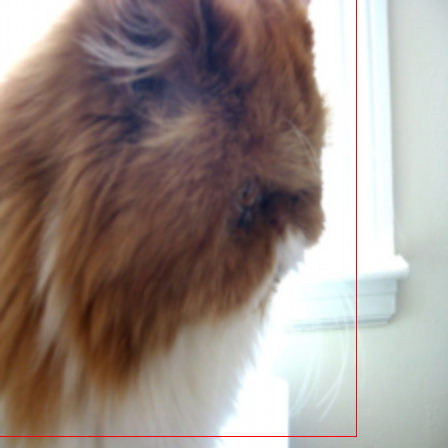

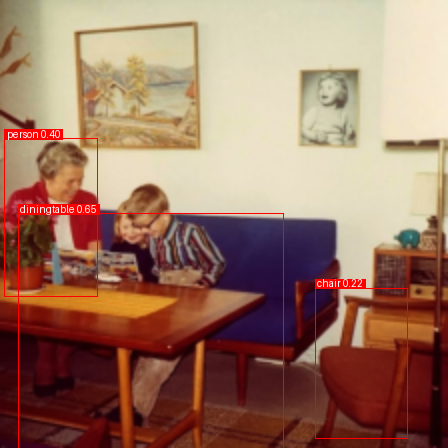

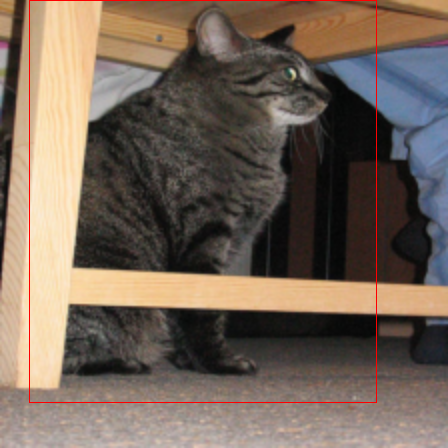

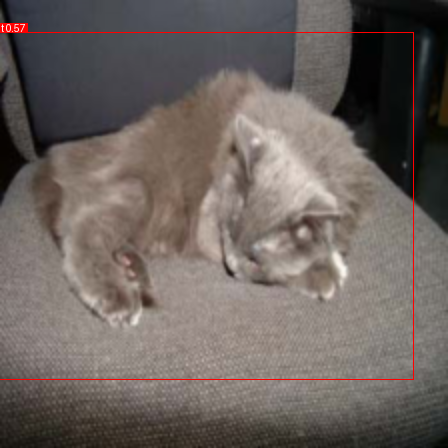

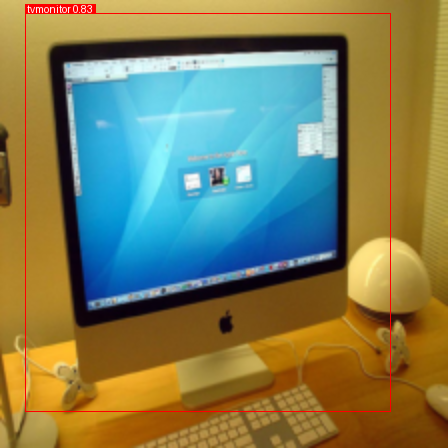

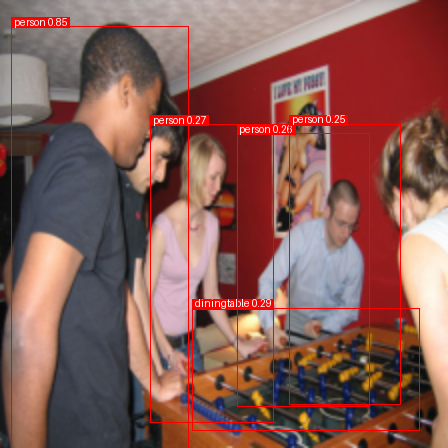

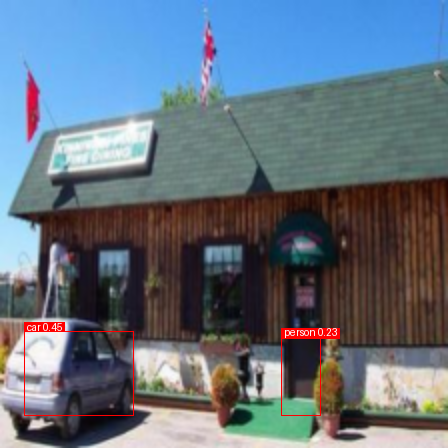

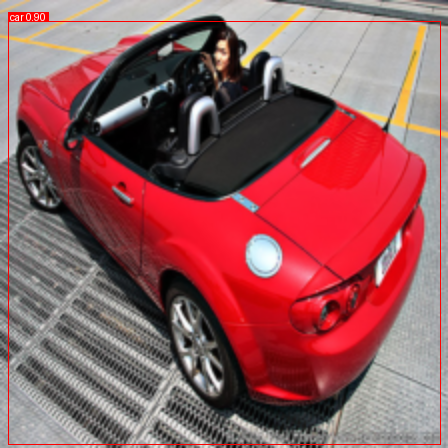

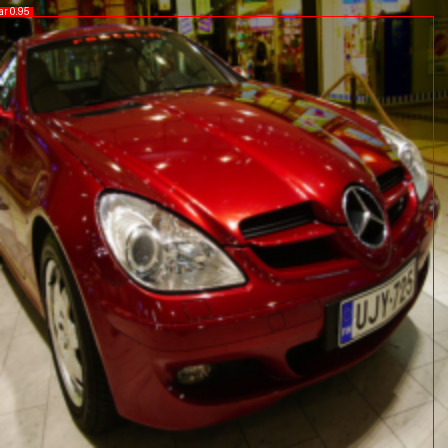

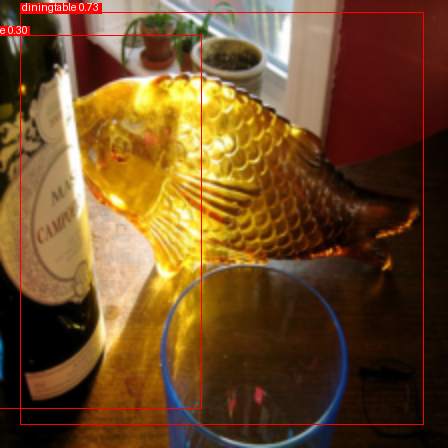

In [82]:
vli = iter(val_loader)

for _ in range(10):
    nms_visualize(yolonet, next(vli))

In [83]:
test_set = torch.utils.data.Subset(val_set, range(1000))
test_batch_size = 64
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

In [84]:
cell_size = image_size / S

labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
          'bus', 'car', 'cat', 'chair', 'cow',
          'diningtable', 'dog', 'horse', 'motorbike', 'person',
          'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [85]:
if os.path.isfile("YOLO_predictions.csv"):
    os.remove("YOLO_predictions.csv")

yolonet.eval()
with open("YOLO_predictions.csv", "w") as f:
    f.write(f"data_num,class_label,class_num,x1,y1,x2,y2\n")
    for i, batch in enumerate(test_loader):
        imgs, _ = batch
        imgs = imgs.to(device)
        with torch.no_grad():
            preds = yolonet(imgs)

        for j, pred in enumerate(preds):
            boxes_ls, scores_ls, class_label_ls, class_num_ls = [], [], [], []
            for sy in range(S):
                for sx in range(S):
                    cell = pred[sy][sx]
                    for b in range(B):
                        if cell[5 * b] > conf_threshold:
                            cell_size = image_size / S

                            class_num = torch.argmax(cell[5*B:])
                            class_label = labels[class_num]
                            class_num_ls.append(class_num)
                            class_label_ls.append(class_label)

                            y1 = cell_size * (sy + cell[5 * b + 2]) - (image_size * cell[5 * b + 4] / 2)
                            x1 = cell_size * (sx + cell[5 * b + 1]) - (image_size * cell[5 * b + 3] / 2)
                            y2 = y1 + image_size * cell[5 * b + 4]
                            x2 = x1 + image_size * cell[5 * b + 3]

                            xyxy = [x1, y1, x2, y2]

                            scores_ls.append(cell[5 * b])
                            boxes_ls.append(xyxy)

            boxes_ls, scores_ls = torch.tensor(boxes_ls), torch.tensor(scores_ls)
            if len(boxes_ls) == 0:
                continue
            filtered_preds = torchvision.ops.nms(boxes_ls, scores_ls, nms_threshold)
            for idx in filtered_preds:
                x1, y1, x2, y2 = boxes_ls[idx]
                class_label, class_num = class_label_ls[idx], class_num_ls[idx]
                f.write(f"{i*test_batch_size + j}, {class_label}, {class_num}, {x1}, {y1}, {x2}, {y2} \n")